# Synchrony Datathalon 2025

## Load the data

In [7]:
import pandas as pd
import numpy as np

# Load all the datasets
account_df = pd.read_csv('data/account_dim_20250325.csv')
fraud_case_df = pd.read_csv('data/fraud_claim_case_20250325.csv')
fraud_tran_df = pd.read_csv('data/fraud_claim_tran_20250325.csv')
rams_df = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_df = pd.read_csv('data/statement_fact_20250325.csv')
syfid_df = pd.read_csv('data/syf_id_20250325.csv')
transaction_df = pd.read_csv('data/transaction_fact_20250325.csv')
wrld_transaction_df = pd.read_csv('data/wrld_stor_tran_fact_20250325.csv')


## Pre Process functions

In [8]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

In [9]:
# Function to clean the account dataset
def pre_process_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. Currently it has the following values: 0, 7, 8 and nan. 0 mean activated and the rest are not activated.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column. Currently it has the following values: H, Y and empty/na/null. Y mean employee, H means high spending customer and empty/na/null means normal customer. I want a separate column for high spending customer and employee. The rest are normal customers.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

In [10]:
def clean_transaction_data(transaction_df):

    df = transaction_df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

## Apply all the preprocessing

In [11]:
updated_rams_df = clean_rams(rams_df)
updated_accounts_df = pre_process_accounts(account_df)
updated_transaction_df=clean_transaction_data(transaction_df)
updated_world_transaction_df=clean_transaction_data(wrld_transaction_df)

C:\Users\mohi2\AppData\Local\Temp\ipykernel_12188\823880188.py:24: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
C:\Users\mohi2\AppData\Local\Temp\ipykernel_12188\823880188.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
C:\Users\mohi2\AppData\Local\Temp\ipykernel_12188\823880188.py:40: FutureWarning: 

In [12]:
# Appened transaction_df and wrld_transaction_df
combined_transaction_df = pd.concat([updated_transaction_df, updated_world_transaction_df], ignore_index=True)
transaction_sales_df = combined_transaction_df[(combined_transaction_df['transaction_type'] == 'SALE') & (combined_transaction_df['transaction_code'] == 253)]
transaction_sales_df.drop(columns=['transaction_type', 'transaction_code', 'frgn_curr_code', 'frgn_tran_amt', 'us_equiv_amt'], inplace=True)
transaction_sales_df.head()

C:\Users\mohi2\AppData\Local\Temp\ipykernel_12188\466746875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df.drop(columns=['transaction_type', 'transaction_code', 'frgn_curr_code', 'frgn_tran_amt', 'us_equiv_amt'], inplace=True)


,current_account_nbr,transaction_date,transaction_amt
0,X7jfKh6xrPAB8Tx6,2024-06-05,15.78
1,yntD77AZDylS48Q4,2024-06-19,14.85
2,LIJPI0sK28Pa7fX2,2024-06-26,136.16
3,CMAr5Apxwdzpvoze,2024-08-15,8.74
4,eJSfTCGPvJulGzd3,2024-08-17,26.65


## EDA

C:\Users\mohi2\AppData\Local\Temp\ipykernel_12188\1813184487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])


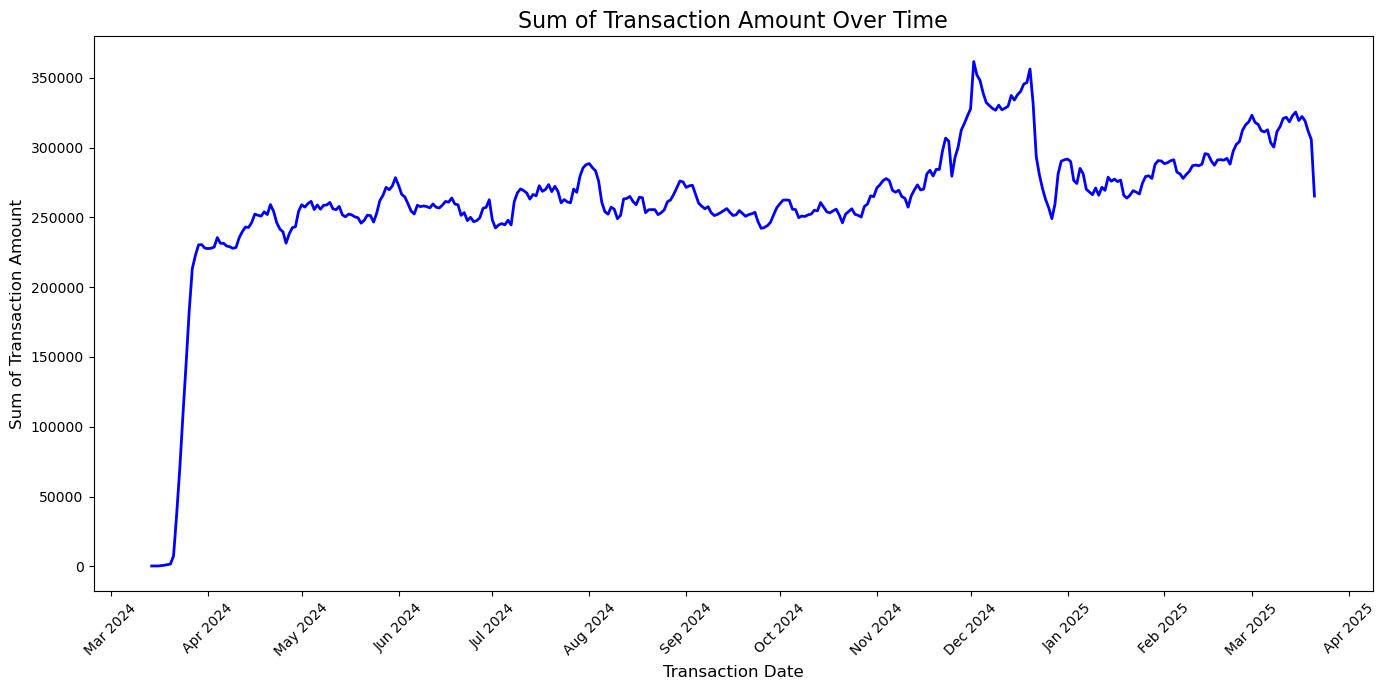

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Calculate the sum of transaction amounts grouped by transaction date
transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])
transaction_sum = transaction_sales_df.groupby('transaction_date')['transaction_amt'].sum()

# Filter data to start from March 2024
transaction_sum_filtered = transaction_sum[transaction_sum.index >= '2024-03-01']

transaction_sum_smoothed = transaction_sum_filtered.rolling(window=7, center=True).mean()

# Plot the sum of transaction amounts over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_sum_smoothed.index, transaction_sum_smoothed.values, color='blue', linewidth=2, label='Transaction Amount')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Sum of Transaction Amount Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Sum of Transaction Amount', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

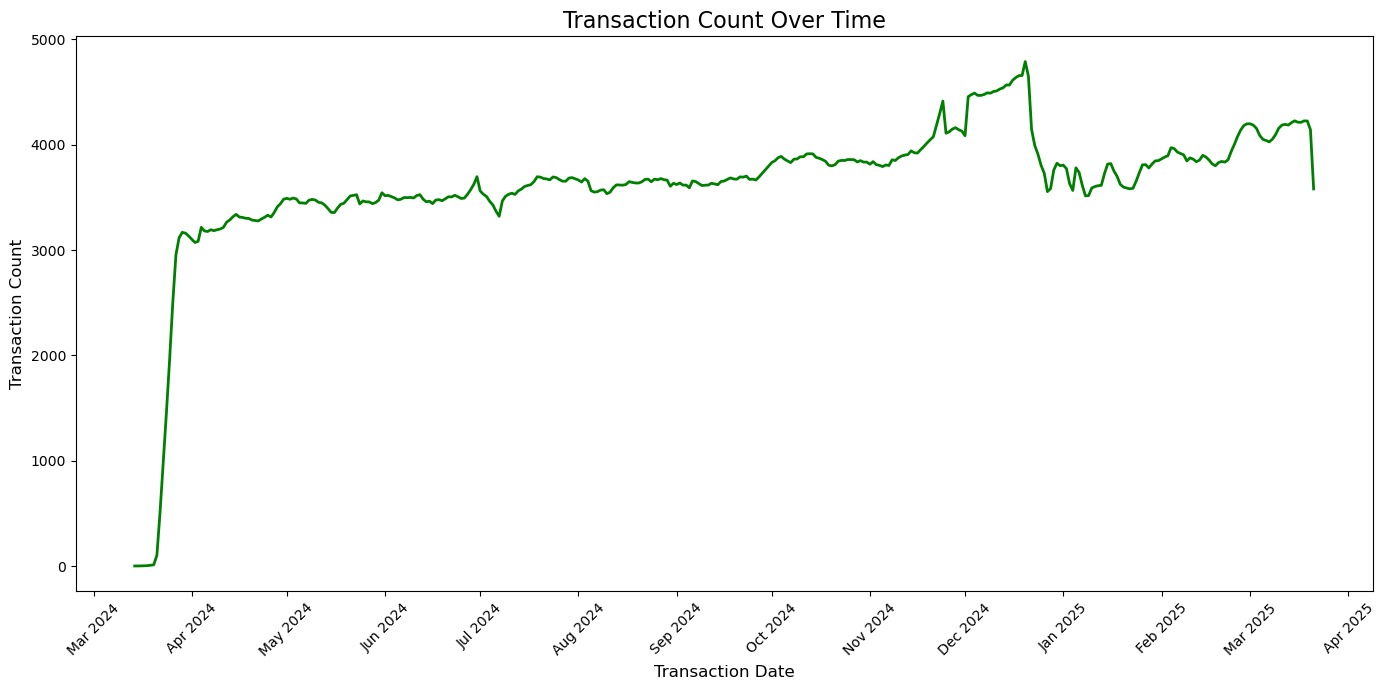

In [14]:
# Calculate the count of transactions grouped by transaction date
transaction_count = transaction_sales_df.groupby('transaction_date').size()

# Filter data to start from March 2024
transaction_count_filtered = transaction_count[transaction_count.index >= '2024-03-01']

transaction_count_smoothed = transaction_count_filtered.rolling(window=7, center=True).mean()

# Plot the transaction count over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_count_smoothed.index, transaction_count_smoothed.values, color='green', linewidth=2, label='Transaction Count')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Transaction Count Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

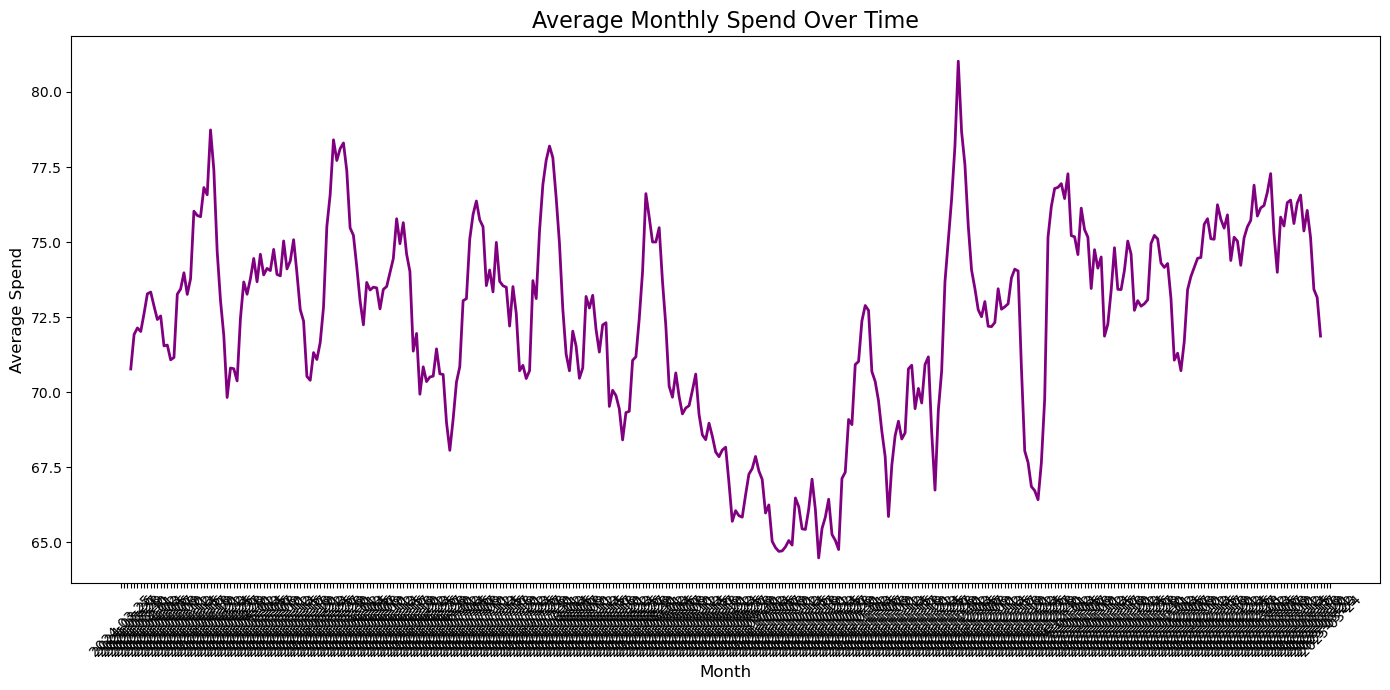

In [15]:
# Calculate the average monthly spend
avg_monthly_spend = transaction_sales_df.groupby('transaction_date')['transaction_amt'].mean()

# Filter data to start from March 2024
avg_monthly_spend_filtered = avg_monthly_spend[avg_monthly_spend.index >= '2024-03-25'].rolling(window=7, center=True).mean()

# Plot the average monthly spend
plt.figure(figsize=(14, 7))
plt.plot(avg_monthly_spend_filtered.index.astype(str), avg_monthly_spend_filtered.values, 
         color='purple', linewidth=2, label='Average Monthly Spend')

# Format the x-axis
plt.xticks(rotation=45)

# Add title and labels
plt.title('Average Monthly Spend Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Spend', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


# Generate Forecasting Model

03:49:23 - cmdstanpy - INFO - Chain [1] start processing
03:49:23 - cmdstanpy - INFO - Chain [1] done processing



Total unique accounts: 12893
Forecasting for account: 4iDkIKpAD5AbzbuF


c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 


2025 Q4 forecast for account 4iDkIKpAD5AbzbuF:
      month         yhat
19  2025-10  2304.266614
20  2025-11  2755.079279
21  2025-12  2451.013078


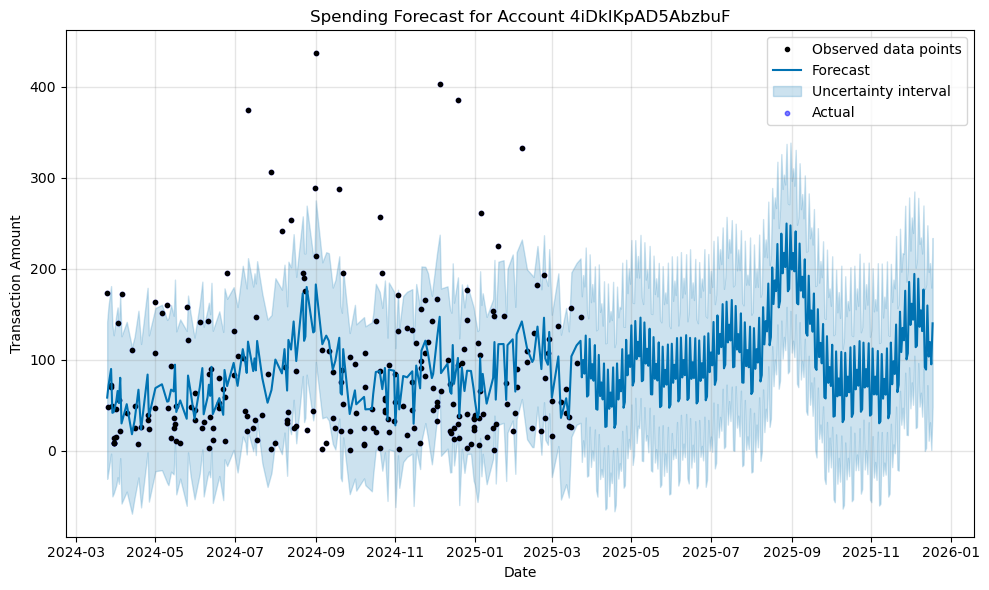

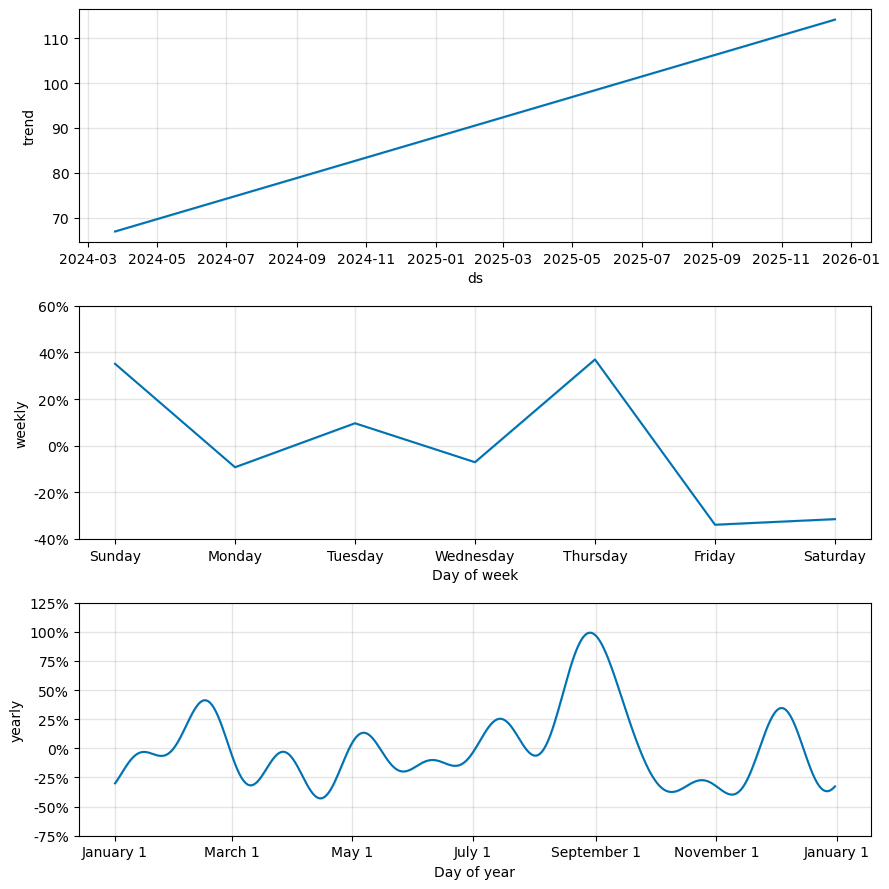

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime


# Prepare data for Prophet
def prepare_account_data(df, account_nbr):
    """Prepare data for a specific account for Prophet forecasting"""
    # Filter data for the specific account
    account_df = df[df['current_account_nbr'] == account_nbr].copy()
    
    # Sort by date
    account_df = account_df.sort_values('transaction_date')
    
    # Rename columns for Prophet
    account_df = account_df.rename(columns={'transaction_date': 'ds', 'transaction_amt': 'y'})
    
    # Select only required columns
    account_df = account_df[['ds', 'y']]
    
    return account_df

# Forecasting function
def forecast_account_spending(account_data, forecast_periods=270):
    """Create and train Prophet model, generate forecasts"""
    # Create and fit the model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'  # Typically better for financial data
    )
    
    model.fit(account_data)
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=forecast_periods)
    
    # Generate forecast
    forecast = model.predict(future)
    
    return model, forecast

# Visualization function
def plot_forecast(model, forecast, account_data, account_nbr):
    """Plot the forecast results"""
    fig = model.plot(forecast)
    plt.title(f'Spending Forecast for Account {account_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Transaction Amount')
    
    # Plot actual values
    plt.scatter(account_data['ds'], account_data['y'], color='blue', s=10, alpha=0.5, label='Actual')
    
    plt.legend()
    plt.tight_layout()
    return fig

# Function to print the 2025 Q4 forecast for a specific account
def print_q4_forecast(forecast, sample_account):
    """Print the 2025 Q4 forecast for a specific account."""
    print(f"\n2025 Q4 forecast for account {sample_account}:")
    # Group the forecast by month and sum up the yhat values
    forecast['month'] = forecast['ds'].dt.to_period('M')
    monthly_forecast = forecast.groupby('month')['yhat'].sum().reset_index()

    # Print the monthly forecast for 2025 Q4
    print(monthly_forecast[(monthly_forecast['month'] >= '2025-10') & (monthly_forecast['month'] <= '2025-12')])

# Get unique account numbers
unique_accounts = transaction_sales_df['current_account_nbr'].unique()
print(f"\nTotal unique accounts: {len(unique_accounts)}")

# Execute for one account
sample_account = unique_accounts[777]
print(f"Forecasting for account: {sample_account}")

# Prepare data for the account
account_data = prepare_account_data(transaction_sales_df, sample_account)

# Train model and generate forecast
model, forecast = forecast_account_spending(account_data)

# Plot results
plot_forecast(model, forecast, account_data, sample_account)

# Show components (trend, yearly seasonality, weekly seasonality)
fig_comp = model.plot_components(forecast)
plt.tight_layout()

print_q4_forecast(forecast, sample_account)

# Function to forecast for all accounts
def forecast_all_accounts(df, unique_accounts, forecast_periods=270):
    """Generate forecasts for all accounts and return results"""
    all_forecasts = {}
    
    for account in unique_accounts:
        print(f"Processing account: {account}")
        
        # Prepare data
        account_data = prepare_account_data(df, account)
        
        # Skip accounts with too few data points
        if len(account_data) < 10:
            print(f"  Skipping account {account}: insufficient data")
            continue
            
        try:
            # Generate forecast
            model, forecast = forecast_account_spending(account_data, forecast_periods)
            
            # Store results
            all_forecasts[account] = {
                'model': model,
                'forecast': forecast,
                'data': account_data
            }
            
        except Exception as e:
            print(f"  Error forecasting account {account}: {str(e)}")
    
    return all_forecasts

# Method to analyzing forecast results
def analyze_forecast_results(all_forecasts):
    """Analyze forecast results to get insights about spending patterns"""
    results = {}
    
    for account, data in all_forecasts.items():
        forecast = data['forecast']
        
        # Get the last actual date
        last_actual_date = data['data']['ds'].max()
        
        # Filter future predictions
        future_forecast = forecast[forecast['ds'] > last_actual_date]
        
        # Calculate metrics
        predicted_total = future_forecast['yhat'].sum()
        predicted_avg = future_forecast['yhat'].mean()
        predicted_max = future_forecast['yhat'].max()
        predicted_trend = future_forecast['trend'].iloc[-1] - future_forecast['trend'].iloc[0]
        
        results[account] = {
            'predicted_total_spending': predicted_total,
            'predicted_avg_spending': predicted_avg,
            'predicted_max_spending': predicted_max,
            'predicted_trend': predicted_trend
        }
    
    return pd.DataFrame(results).T

# Uncomment the following code to run forecasting for all accounts (WARNING: This may take a long time depending on the number of accounts)
# all_forecasts = forecast_all_accounts(transaction_sales_df, unique_accounts)
# forecast_analysis = analyze_forecast_results(all_forecasts)
# print("\nForecast Analysis:")
# print(forecast_analysis.sort_values('predicted_total_spending', ascending=False).head(10))